# KMeans

### Import the packages and data 

In [1]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [12, 12]
pd.set_option("precision", 5)

In [2]:
data = pd.read_csv('Data/customer_data.csv')

In [3]:
pca_data = pd.read_csv('Data/pca_customer_data.csv')
#data = table.to_pandas()

In [4]:
data.shape

(810341, 7)

In [5]:
pca_data.shape

(810341, 16)

### Edit PCA df 

In [6]:
pca_data.head(2)

,Unnamed: 0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,UniqueID
0,0,-0.36368,-0.07125,0.02035,-0.03988,0.26995,-0.14028,0.76859,0.41567,-0.24630,-0.00124,0.22165,-0.38622,-0.35088,0.76266,5962ec84553dcb84e508e2fc45789278
1,1,-0.36494,-0.19491,0.02874,-0.20343,0.11951,0.63265,1.10307,0.02585,-0.00788,-0.10726,-0.13155,-0.14486,-0.01571,-0.01835,547c0d52bbfe1b93b9411d7b55f3bd82


In [7]:
del pca_data["Unnamed: 0"]
pca_data = pca_data.drop(columns="UniqueID")

In [8]:
pca_data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
0,-0.36368,-0.07125,0.02035,-0.03988,0.26995,-0.14028,0.76859,0.41567,-0.24630,-0.00124,0.22165,-0.38622,-0.35088,0.76266
1,-0.36494,-0.19491,0.02874,-0.20343,0.11951,0.63265,1.10307,0.02585,-0.00788,-0.10726,-0.13155,-0.14486,-0.01571,-0.01835
2,-0.36073,-0.13856,0.00033,-0.07730,0.06696,-0.05990,0.01344,0.14090,-0.16061,0.09449,0.45172,0.00763,-0.33428,0.78242
3,-0.37153,0.09313,0.70203,-0.20990,-0.37500,0.01482,-0.19426,0.18343,-0.24443,0.09521,0.50376,-0.39685,0.68774,-0.16549
4,-0.35632,-0.14719,0.03584,-0.27739,0.76592,0.11624,-0.36774,-0.05292,0.00815,0.19761,0.27030,-0.33023,-0.31660,0.79647


### Edit Customer df

In [164]:
#data = data[0:1000]

In [9]:
data.head(2)

,Unnamed: 0,UniqueID,FrequencyofVisits,Age,Sex,Payer,Facility
0,0,5962ec84553dcb84e508e2fc45789278,12,37.0,Feminino,ADVANCECARE,CCB
1,1,547c0d52bbfe1b93b9411d7b55f3bd82,3,37.0,Feminino,ADVANCECARE,HCP


In [10]:
del data["Unnamed: 0"]
data = data.drop(columns="UniqueID")

In [11]:
data.head(2)

,FrequencyofVisits,Age,Sex,Payer,Facility
0,12,37.0,Feminino,ADVANCECARE,CCB
1,3,37.0,Feminino,ADVANCECARE,HCP


## Working with K-means

### Loading the data 

In [46]:
pca_data.dtypes

PC1     float64
PC2     float64
PC3     float64
PC4     float64
PC5     float64
PC6     float64
PC7     float64
PC8     float64
PC9     float64
PC10    float64
PC11    float64
PC12    float64
PC13    float64
PC14    float64
dtype: object

In [12]:
pca_data.isnull().values.any()

False

### K-means

In [13]:
from sklearn.cluster import KMeans

In [16]:
data_processed= pca_data #.dropna()

In [17]:
estimator_kmeans = KMeans(random_state=42, n_clusters=3)
estimator_kmeans.fit(data_processed)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [27]:
cluster_id = estimator_kmeans.labels_
#cluster_labels

In [52]:
#seperate the data into test and train and use train all the way and use ".predict" for the test

In [19]:
centroids = estimator_kmeans.cluster_centers_

In [20]:
centroids.shape

(3, 14)

In [21]:
estimator_kmeans.inertia_

1034150.2068234462

In [22]:
from sklearn.metrics import euclidean_distances

In [23]:
centroid_distances = euclidean_distances(centroids)

In [24]:
centroid_distances.shape

(3, 3)

In [25]:
estimator_kmeans.labels_.shape

(810341,)

In [28]:
#Add cluster label to both df's
data['cluster_id'] = cluster_id
data_processed['cluster_id'] = cluster_id

In [29]:
numerical_data = data.select_dtypes(np.number)
categorical_data = data.select_dtypes([object, "category"])

In [30]:
data.head()

,FrequencyofVisits,Age,Sex,Payer,Facility,cluster_id
0,12,37.0,Feminino,ADVANCECARE,CCB,2
1,3,37.0,Feminino,ADVANCECARE,HCP,2
2,2,37.0,Feminino,ENTIDADES COM DESCONTO,CCB,2
3,16,37.0,Feminino,MÉDIS,HCS,2
4,1,37.0,Feminino,PARTICULARES,CCB,2


In [71]:
def cluster_summary(cluster_id):
    cluster = data[data.cluster_id==cluster_id]
    cluster_summary = cluster[categorical_data.columns].mode().to_dict(orient="records")[0]
    cluster_summary.update(cluster.mean().to_dict())
    return cluster_summary

In [32]:
#cluster = data[data.cluster_id==2]
#cluster[categorical_data.columns].mode().to_dict(orient="records")

[{'Sex': 'Feminino', 'Payer': 'MÉDIS', 'Facility': 'HCD'}]

In [84]:
# Distance between centroid of cluster 0 and 2 
#centroid_distances[0,2]

1.2436452524992418

In [72]:
def cluster_comparison(*cluster_ids):
    summaries = []
    for cluster_id in cluster_ids:
        summaries.append(cluster_summary(cluster_id))
    return pd.DataFrame(summaries).set_index("cluster_id").T

In [37]:
cluster_comparison(0,1,2)

cluster_id,0.0,1.0,2.0
Age,51.749,52.08,51.608
Facility,HCP,HCD,HCD
FrequencyofVisits,8.1547,7.6543,7.5119
Payer,ADSE,MULTICARE,MÉDIS
Sex,Feminino,Masculino,Feminino


In [105]:
def kmeans_cluster(df, n_clusters=2):
    model = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = model.fit_predict(df)
    cluster_results = df.copy()
    cluster_results['Cluster'] = clusters
    return cluster_results

def graph_summary_clustering(results):
    cluster_size = results.groupby(['Cluster']).size().reset_index()
    cluster_size.columns = ['Cluster', 'Count']
    cluster_means = results.groupby(['Cluster'], as_index=False).mean()
    cluster_summary = pd.merge(cluster_size, cluster_means, on='Cluster')
    cluster_summary = cluster_summary.drop(["Count"], axis=1).set_index("Cluster")
    return cluster_summary[sorted(cluster_summary.columns)]

### Ideal number of clusters?

In [ ]:
# Create a function that evaluates the intertia and percentage variance explained for a value of K
def evaluate_k_kmeans(k, scoring, **kwargs):
    scoring_measure = None
    if scoring=="inertia":
        scoring_measure = inertia_measure
    elif scoring=="variance":
        scoring_measure = variance_measure
        
    estimator_kmeans = KMeans(random_state=42, n_clusters=k)
    estimator_kmeans.fit(data_processed)
    return scoring_measure(estimator_kmeans, **kwargs)

In [ ]:
%%time
range_k = [1,2,3,4,5,6]
results_k = {}
for k in range_k:
    results_k[k] = evaluate_k_kmeans_inertia(k)

In [ ]:
results_k

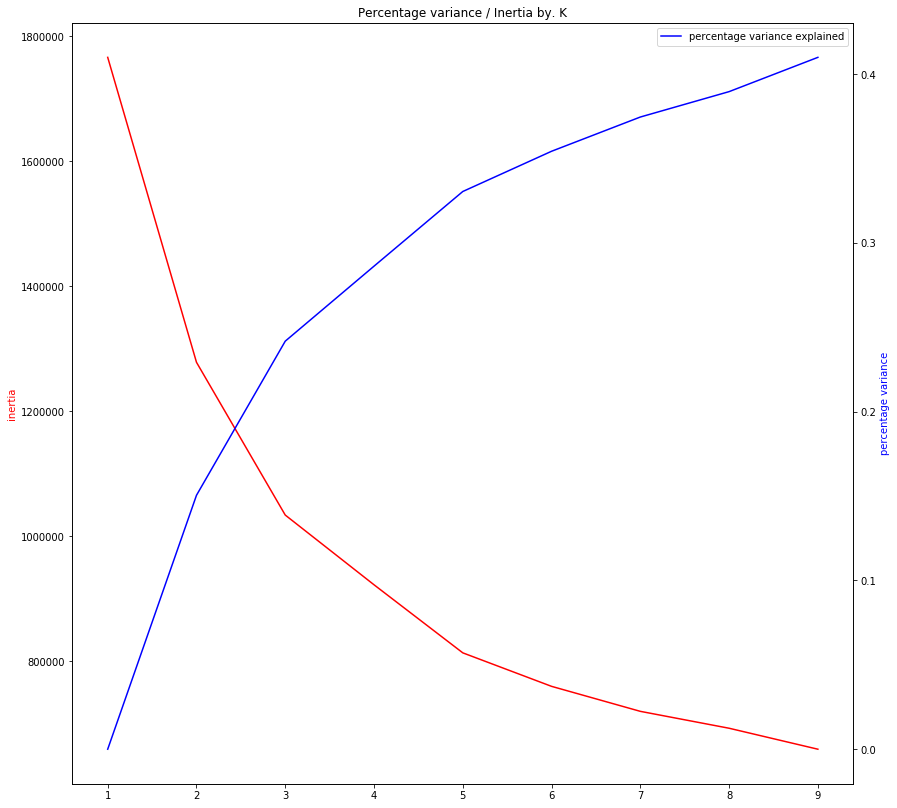

In [48]:
fig, ax1 = plt.subplots()

ax1.plot(
    [c[0] for c in results_k.items()],
    [c[1][0] for c in results_k.items()], label="inertia", color="red")
ax1.set_ylabel('inertia', color="red")


ax2 = ax1.twinx()
ax2.plot(
    [c[0] for c in results_k.items()],
    [c[1][1] for c in results_k.items()], label="percentage variance explained", color="blue")
ax2.set_ylabel('percentage variance', color='blue')

plt.xlabel("K")
plt.legend()
plt.title("Percentage variance / Inertia by. K");

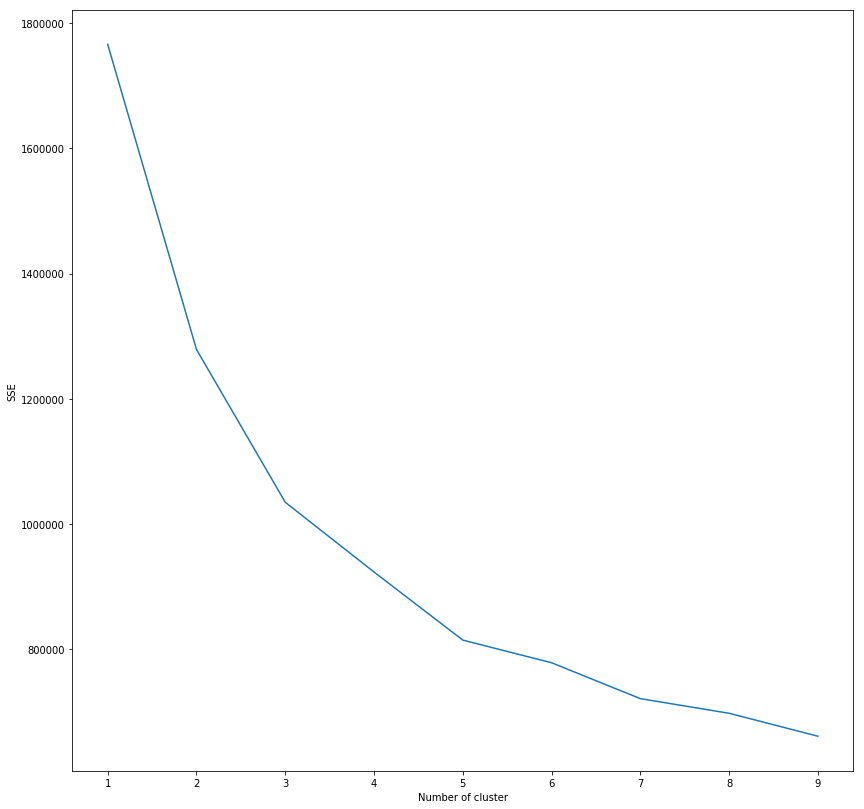

In [49]:
sse = {}
for k in range(1, 10):
   kmeans = KMeans(n_clusters=k).fit(data_processed)
   #print(data["clusters"])
   sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

## Update the number of clusters 

In [75]:
clusterer = KMeans(n_clusters=2)
clusterer.fit(data_processed)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [106]:
cluster_results = kmeans_cluster(data, 2)

ValueError: could not convert string to float: 'HCS'

In [ ]:
cluster_summary = graph_summary_clustering(cluster_results);

In [ ]:
matplotlib.rcParams['figure.figsize'] = [14, 14]
import seaborn as sns
sns.heatmap(cluster_summary.transpose(), annot=True);

### Evaluate the clusters

In [78]:
pd.Series(clusterer.labels_).value_counts()

0    435073
1    375268
dtype: int64

In [79]:
cluster_id = clusterer.labels_
data["cluster_id"] = cluster_id

In [80]:
data.head()

,FrequencyofVisits,Age,Sex,Payer,Facility,cluster_id
0,12,37.0,Feminino,ADVANCECARE,CCB,1
1,3,37.0,Feminino,ADVANCECARE,HCP,1
2,2,37.0,Feminino,ENTIDADES COM DESCONTO,CCB,1
3,16,37.0,Feminino,MÉDIS,HCS,1
4,1,37.0,Feminino,PARTICULARES,CCB,1


In [81]:
data.cluster_id.unique()

array([1, 0])

In [83]:
cluster_comparison(0,1)

cluster_id,0.0,1.0
Age,51.961,51.608
Facility,HCD,HCD
FrequencyofVisits,7.8341,7.5119
Payer,ADSE,MÉDIS
Sex,Masculino,Feminino


In [200]:
estimator_kmeans.inertia_

1386.3767842926277

MiniBatchKMeans is faster and has a higher inertia.

## Internal Evaluation metrics

In [97]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import silhouette_score, calinski_harabaz_score 

In [94]:
cross_val_score(clusterer, data_processed, y=None, 
                scoring=silhouette_score_cv, cv=3).mean() #a small value means it is well matched

0.2579394917267587

In [100]:
data_processed.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,cluster_id
0,-0.36368,-0.07125,0.02035,-0.03988,0.26995,-0.14028,0.76859,0.41567,-0.24630,-0.00124,0.22165,-0.38622,-0.35088,0.76266,2
1,-0.36494,-0.19491,0.02874,-0.20343,0.11951,0.63265,1.10307,0.02585,-0.00788,-0.10726,-0.13155,-0.14486,-0.01571,-0.01835,2
2,-0.36073,-0.13856,0.00033,-0.07730,0.06696,-0.05990,0.01344,0.14090,-0.16061,0.09449,0.45172,0.00763,-0.33428,0.78242,2
3,-0.37153,0.09313,0.70203,-0.20990,-0.37500,0.01482,-0.19426,0.18343,-0.24443,0.09521,0.50376,-0.39685,0.68774,-0.16549,2
4,-0.35632,-0.14719,0.03584,-0.27739,0.76592,0.11624,-0.36774,-0.05292,0.00815,0.19761,0.27030,-0.33023,-0.31660,0.79647,2


In [101]:
calinski_harabaz_score(data_processed, cluster_id)

309234.2572875792